In [2]:
from dolfinx import mesh, fem, nls, cpp
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl
import numpy as np
from mpi4py import MPI

# Create mesh and function space
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
V = fem.functionspace(domain, ("CG", 2, (2,)))

# Define material properties
E = 210e9  # Young's modulus (Pa)
v = 0.3    # Poisson's ratio
sigma_Y = 250e6  # Yield stress (Pa)
C_k = 10e9  # Kinematic hardening modulus

# Define elasticity parameters
mu = E / (2 * (1 + v))
lambda_ = E * v / ((1 + v) * (1 - 2 * v))

def epsilon(u):
    return ufl.sym(ufl.grad(u))

def sigma(u):
    epsilon = epsilon(u)
    return lambda_ * ufl.tr(epsilon) * ufl.Identity(2) + 2 * mu * epsilon

def sigma_dev(sigma):
    return sigma - (1/3) * ufl.tr(sigma) * ufl.Identity(2)

# Define trial and test functions
v = ufl.TestFunction(V)
u = ufl.TrialFunction(V)
u_k = fem.Function(V)  # Displacement field

# Initial conditions
W = fem.functionspace(domain, ("DG", 0, (2, 2)))
sigma_old = fem.Function(W)
alpha_old = fem.Function(W)
eps_p_old = fem.Function(W)

# Define elastic trial stress
sigma_trial = sigma(u_k)
s_trial = sigma_dev(sigma_trial)

# Compute yield function
f_trial = ufl.sqrt(ufl.inner(s_trial - alpha_old, s_trial - alpha_old)) - sigma_Y

# Return mapping (Plastic correction)
delta_lambda = ufl.conditional(f_trial > 0, f_trial / (2 * mu + C_k), 0)
eps_p_new = eps_p_old + delta_lambda * (s_trial - alpha_old) / ufl.sqrt(ufl.inner(s_trial - alpha_old, s_trial - alpha_old))
alpha_new = alpha_old + C_k * (eps_p_new - eps_p_old)

# Compute updated stress
sigma_new = sigma(u_k) - 2 * mu * (eps_p_new - eps_p_old)

# Define variational problem
residual = ufl.inner(sigma_new, epsilon(v)) * ufl.dx
problem = NonlinearProblem(residual, u_k, bcs=[])
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u_k)


TimeoutError: JIT compilation timed out, probably due to a failed previous compile. Try cleaning cache (e.g. remove /root/.cache/fenics/libffcx_forms_ae6a141403a158277e6ea637876432621dd4b44d.c) or increase timeout option.

In [ ]:
from dolfinx import mesh, fem, nls, cpp, common
import ufl
import numpy as np
from mpi4py import MPI

# Increase JIT compilation timeout
common.jit_parameters["timeout"] = 600  # 10 minutes

# Create mesh and function space
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
V = fem.functionspace(domain, ("CG", 2, (2,)))

# Define material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3    # Poisson's ratio
sigma_Y = 250e6  # Yield stress (Pa)
C_k = 10e9  # Kinematic hardening modulus

# Define elasticity parameters
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

def strain(u):
    return ufl.sym(ufl.grad(u))

def stress(u):
    epsilon = strain(u)
    return lambda_ * ufl.tr(epsilon) * ufl.Identity(2) + 2 * mu * epsilon

def deviatoric_stress(sigma):
    return sigma - (1/3) * ufl.tr(sigma) * ufl.Identity(2)

# Define trial and test functions
nu = ufl.TestFunction(V)
du = ufl.TrialFunction(V)
u_ = fem.Function(V)  # Displacement field

# Initial conditions
sigma_old = fem.Function(fem.TensorFunctionSpace(domain, (ufl.FiniteElement("DG", domain.ufl_cell(), 0))))
alpha_old = fem.Function(fem.TensorFunctionSpace(domain, (ufl.FiniteElement("DG", domain.ufl_cell(), 0))))
eps_p_old = fem.Function(fem.TensorFunctionSpace(domain, (ufl.FiniteElement("DG", domain.ufl_cell(), 0))))

# Define elastic trial stress
sigma_trial = stress(u_)
s_trial = deviatoric_stress(sigma_trial)

# Compute yield function
f_trial = ufl.sqrt(ufl.inner(s_trial - alpha_old, s_trial - alpha_old)) - sigma_Y

# Return mapping (Plastic correction)
delta_lambda = ufl.conditional(f_trial > 0, f_trial / (2 * mu + C_k + 1e-8), 0)  # Small epsilon added for numerical stability
eps_p_new = eps_p_old + delta_lambda * (s_trial - alpha_old) / ufl.sqrt(ufl.inner(s_trial - alpha_old, s_trial - alpha_old) + 1e-8)
alpha_new = alpha_old + C_k * (eps_p_new - eps_p_old)

# Compute updated stress
sigma_new = stress(u_) - 2 * mu * (eps_p_new - eps_p_old)

# Define variational problem
residual = ufl.inner(sigma_new, strain(nu)) * ufl.dx
problem = fem.petsc.NonlinearProblem(residual, u_, bcs=[])
solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)

# Improve solver debugging and tolerance settings
solver.atol = 1e-8
solver.rtol = 1e-8
solver.report = True
solver.solve(u_)


In [3]:
from dolfinx import mesh, fem
import ufl
from mpi4py import MPI

# Create mesh and function space
msh = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
V = fem.functionspace(msh, ("Lagrange", 1))

# Define trial and test functions
u = fem.Function(V)
du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define a basic linear form (Laplace problem)
f = fem.Constant(msh, 1.0)
a = ufl.inner(ufl.grad(du), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx  # RHS

# Assemble the Jacobian
A = fem.assemble_matrix(a)  # This should work
A.assemble()
print(A)


AttributeError: 'Form' object has no attribute '_cpp_object'

In [4]:
import dolfinx
print(dolfinx.__version__)


0.9.0


In [1]:
import numpy as np

In [3]:
x1 = [1, 2, 3]
x2 = [4, 5, 6]
print(np.concatenate((x1, x2), axis=0))

[1 2 3 4 5 6]


In [8]:
np.concatenate(np.dstack([x1, x2]).reshape(len(x1),-1))

array([1, 4, 2, 5, 3, 6])

In [10]:
import numpy as np

In [24]:
with open("in_data.npy", "rb") as f:
    input_data_std = np.load(f)

with open("out_data.npy", "rb") as f:
    target_data_std = np.load(f)

with open("results/training_in_v10.npy", "rb") as f:
    input_data = np.load(f)

with open("results/training_out_v10.npy", "rb") as f:
    target_data = np.load(f)

In [25]:
input_data.shape

(21, 6000, 42)

In [26]:
input_data[10, 500]

array([-1.42366475e+00,  2.30967393e+00, -1.25401746e+00,  2.30968282e+00,
       -1.06827308e+00,  2.30968678e+00, -8.85014582e-01,  2.30969631e+00,
       -7.16106141e-01,  2.30969665e+00, -5.65369588e-01,  2.30969076e+00,
       -4.31732728e-01,  2.30968125e+00, -3.11980302e-01,  2.30967376e+00,
       -2.02456260e-01,  2.30967155e+00, -9.95907033e-02,  2.30967495e+00,
        2.72570870e-06,  2.30968267e+00,  9.95950261e-02,  2.30969294e+00,
        2.02457171e-01,  2.30970406e+00,  3.11975577e-01,  2.30971452e+00,
        4.31720680e-01,  2.30972283e+00,  5.65350116e-01,  2.30972792e+00,
        7.16081771e-01,  2.30973026e+00,  8.84989127e-01,  2.30973191e+00,
        1.06824741e+00,  2.30973453e+00,  1.25400249e+00,  2.30973427e+00,
        1.42366050e+00,  2.30972958e+00])

In [27]:
input_data_std[10, 500]

array([-1.2361686,  1.2361686, -1.2361686,  1.2361686, -1.2361686,
        1.2361686, -1.2361686,  1.2361686, -1.2361686,  1.2361686,
       -1.2361686,  1.2361686, -1.2361686,  1.2361686, -1.2361686,
        1.2361686, -1.2361686,  1.2361686, -1.2361686,  1.2361686,
        1.2361686,  1.2361686,  1.2361686,  1.2361686,  1.2361686,
        1.2361686,  1.2361686,  1.2361686,  1.2361686,  1.2361686,
        1.2361686,  1.2361686,  1.2361686,  1.2361686,  1.2361686,
        1.2361686,  1.2361686,  1.2361686,  1.2361686,  1.2361686,
        1.2361686,  1.2361686], dtype=float32)

In [34]:
target_data[10, 501]

array([ 7.46943347e-01, -1.53764368e+04,  7.96296773e-02, -1.93605081e+04,
       -2.19998912e-01, -2.12996313e+04,  1.43019650e-01, -2.25713394e+04,
       -1.97198544e-01, -2.31792238e+04, -2.38799960e-01, -2.35008937e+04,
       -2.41783240e-01, -2.36754289e+04, -1.75749392e-01, -2.37841314e+04,
       -1.09723244e-01, -2.38524118e+04, -6.22086032e-02, -2.38913017e+04,
       -3.88717478e-02, -2.39039549e+04, -3.35167903e-02, -2.38912227e+04,
       -3.87467156e-02, -2.38522524e+04, -5.12403996e-02, -2.37839010e+04,
       -6.89902094e-02, -2.36751645e+04, -8.07799093e-02, -2.35007033e+04,
       -4.67842115e-02, -2.31791398e+04,  1.38286275e-02, -2.25714512e+04,
        6.06175941e-02, -2.12994180e+04,  1.22545671e-01, -1.93607750e+04,
        2.01442105e-02, -1.53763933e+04])

In [35]:
target_data_std[10, 501]

array([ 1.2317793, -1.2317793,  1.2317793, -1.2317793, -1.2317793,
       -1.2317793,  1.2317793, -1.2317793, -1.2317793, -1.2317793,
       -1.2317793, -1.2317793, -1.2317793, -1.2317793, -1.2317793,
       -1.2317793, -1.2317793, -1.2317793, -1.2317793, -1.2317793,
       -1.2317793, -1.2317793, -1.2317793, -1.2317793, -1.2317793,
       -1.2317793, -1.2317793, -1.2317793, -1.2317793, -1.2317793,
       -1.2317793, -1.2317793, -1.2317793, -1.2317793,  1.2317793,
       -1.2317793,  1.2317793, -1.2317793,  1.2317793, -1.2317793,
        1.2317793, -1.2317793], dtype=float32)

In [1]:
import pickle

In [2]:
from shared.tct import tct_comp
from tct.tct_tractions import TCTExtractTractions, TCTApplyTractions

In [3]:
with open("results/model_v10.pkl", "rb") as f:
    predictor = pickle.load(f)

predictor.initialize_memory_variables()
tct_comp(TCTExtractTractions(), TCTApplyTractions(predictor), "lstm_test")

No Neumann BCs applied to this function space.


[██████████████████████████████████████████████████] 6000/6000



error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


[██████████████████████████████████████████████████] 6000/6000



error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [1]:
import numpy as np

In [2]:
with open("results/training_in_v11.npy", "rb") as f:
    data_in_11 = np.load(f)

with open("results/training_in_v10.npy", "rb") as f:
    data_in_10 = np.load(f)

In [3]:
with open("results/training_out_v11.npy", "rb") as f:
    data_out_11 = np.load(f)

with open("results/training_out_v10.npy", "rb") as f:
    data_out_10 = np.load(f)

In [11]:
data_out_11[8, 1400, :]

array([ 2.65818711e-11,  1.65587597e+04, -3.08583847e-11,  2.08495511e+04,
        1.94991432e-11,  2.29376312e+04, -1.84535203e-12,  2.43075123e+04,
        7.52735045e-12,  2.49620075e+04, -2.17156879e-11,  2.53083431e+04,
        3.56796556e-11,  2.54962295e+04, -3.80570176e-11,  2.56133081e+04,
       -3.40639078e-11,  2.56868902e+04,  2.15175390e-11,  2.57288286e+04,
        3.96708177e-11,  2.57425030e+04, -2.52229125e-11,  2.57288286e+04,
       -1.73595099e-11,  2.56868902e+04, -1.66611994e-11,  2.56133081e+04,
        2.28862636e-11,  2.54962295e+04, -2.46797474e-11,  2.53083431e+04,
        4.30909166e-11,  2.49620075e+04,  1.49337337e-11,  2.43075123e+04,
        1.17704812e-11,  2.29376312e+04, -5.49215996e-11,  2.08495511e+04,
        1.05324915e-10,  1.65587597e+04])

In [10]:
data_out_10[0, 1400, :]

array([ 6.55483991e-01, -1.34936715e+04,  6.98794345e-02, -1.69899139e+04,
       -1.93061181e-01, -1.86916014e+04,  1.25507633e-01, -1.98075954e+04,
       -1.73052601e-01, -2.03410476e+04, -2.09560138e-01, -2.06233306e+04,
       -2.12178131e-01, -2.07764948e+04, -1.54229786e-01, -2.08718873e+04,
       -9.62881997e-02, -2.09318071e+04, -5.45914809e-02, -2.09659352e+04,
       -3.41121030e-02, -2.09770390e+04, -2.94128323e-02, -2.09658658e+04,
       -3.40023803e-02, -2.09316672e+04, -4.49662772e-02, -2.08716851e+04,
       -6.05427145e-02, -2.07762629e+04, -7.08888265e-02, -2.06231635e+04,
       -4.10557264e-02, -2.03409738e+04,  1.21353835e-02, -1.98076936e+04,
        5.31952827e-02, -1.86914143e+04,  1.07540586e-01, -1.69901480e+04,
        1.76776560e-02, -1.34936333e+04])

In [5]:
with open("in_data_11.npy", "rb") as f:
    in_norm_11 = np.load(f)

with open("out_data_11.npy", "rb") as f:
    out_norm_11 = np.load(f)

with open("in_data_10.npy", "rb") as f:
    in_norm_10 = np.load(f)

with open("out_data_10.npy", "rb") as f:
    out_norm_10 = np.load(f)

In [10]:
in_norm_11[10, 5999, :]

array([ 1.492372 , -1.492372 ,  1.492372 , -1.492372 ,  1.492372 ,
       -1.492372 ,  1.492372 , -1.492372 ,  1.492372 , -1.492372 ,
        1.492372 , -1.492372 ,  1.492372 , -1.492372 ,  1.492372 ,
       -1.492372 ,  1.492372 , -1.492372 ,  1.492372 , -1.492372 ,
        1.4443531, -1.492372 , -1.492372 , -1.492372 , -1.492372 ,
       -1.492372 , -1.492372 , -1.492372 , -1.492372 , -1.492372 ,
       -1.492372 , -1.492372 , -1.492372 , -1.492372 , -1.492372 ,
       -1.492372 , -1.492372 , -1.492372 , -1.492372 , -1.492372 ,
       -1.492372 , -1.492372 ], dtype=float32)

In [7]:
in_norm_10[1, 1402, :]

array([-0.73717856,  0.73717856, -0.73717856,  0.73717856, -0.73717856,
        0.73717856, -0.73717856,  0.73717856, -0.73717856,  0.73717856,
       -0.73717856,  0.73717856, -0.73717856,  0.73717856, -0.73717856,
        0.73717856, -0.73717856,  0.73717856, -0.73717856,  0.73717856,
        0.73717856,  0.73717856,  0.73717856,  0.73717856,  0.73717856,
        0.73717856,  0.73717856,  0.73717856,  0.73717856,  0.73717856,
        0.73717856,  0.73717856,  0.73717856,  0.73717856,  0.73717856,
        0.73717856,  0.73717856,  0.73717856,  0.73717856,  0.73717856,
        0.73717856,  0.73717856], dtype=float32)

In [9]:
out_norm_11[10, 5999, :]

array([ 0.5659403 ,  1.4922491 , -0.90534586,  1.4922491 ,  0.77459246,
        1.4922491 , -0.02290907,  1.4922491 , -1.1207155 ,  1.4922491 ,
        0.8028389 ,  1.4922491 ,  1.9793295 ,  1.4922491 , -0.96400976,
        1.4922491 , -1.3302284 ,  1.4922491 , -0.5115989 ,  1.4922491 ,
        1.8324044 ,  1.4922491 , -1.2943527 ,  1.4922491 , -1.2925913 ,
        1.4922491 , -1.5913948 ,  1.4922491 , -0.8503976 ,  1.4922491 ,
       -0.27346236,  1.4922491 ,  2.398705  ,  1.4922491 ,  1.1161748 ,
        1.4922491 ,  0.8510471 ,  1.4922491 , -2.670135  ,  1.4922491 ,
        2.1109974 ,  1.4922491 ], dtype=float32)

In [ ]:
out_norm_10[1, 1200, :]

array([ 1.0973656, -1.0973656,  1.0973656, -1.0973656, -1.0973656,
       -1.0973656,  1.0973656, -1.0973656, -1.0973656, -1.0973656,
       -1.0973656, -1.0973656, -1.0973656, -1.0973656, -1.0973656,
       -1.0973656, -1.0973656, -1.0973656, -1.0973656, -1.0973656,
       -1.0973656, -1.0973656, -1.0973656, -1.0973656, -1.0973656,
       -1.0973656, -1.0973656, -1.0973656, -1.0973656, -1.0973656,
       -1.0973656, -1.0973656, -1.0973656, -1.0973656,  1.0973656,
       -1.0973656,  1.0973656, -1.0973656,  1.0973656, -1.0973656,
        1.0973656, -1.0973656], dtype=float32)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tct.tct_tractions_comp import TCTExtractTractions, TCTApplyFixedTractions

In [3]:
tct = TCTExtractTractions(frequency=1000)
# tct.time_total = 5e-5
tct.run()

No Neumann BCs applied to this function space.
No Neumann BCs applied to this function space.


Solved step 0, ||u_|| = 0.00, ||alpha_|| = 0.00....] 0/6000


IndexError: map::at

In [4]:
tct.postprocess("u", "u", "y", "tractions_full")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [5]:
tct_apply = TCTApplyFixedTractions(tct.data_out, frequency=1000)
tct_apply.run()

[██████████████████████████████████████████████████] 6000/6000



In [6]:
tct_apply.postprocess("u", "u", "y", "tractions_applied")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [7]:
u_k_app_error = np.zeros(tct.formatted_plot_results["u"].shape)
u_k_app_error[:, tct.bottom_half_nodes, :] = tct.formatted_plot_results["u"][:, tct.bottom_half_nodes, :] - tct_apply.formatted_plot_results["u"][:, tct_apply.bottom_half_nodes, :]
tct.postprocess(u_k_app_error, "u", "norm", "tractions_applied_error")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


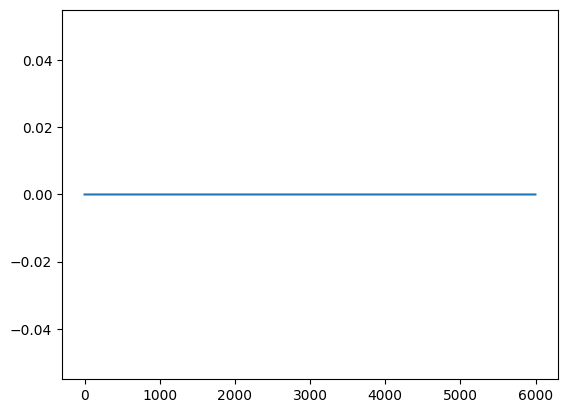

In [5]:
plt.plot(tct.data_out[:, 21])

In [11]:
tct.formatted_plot_results["u"][10, tct.bottom_half_nodes, :]

array([[ 1.16944018e-15,  5.00000000e+00,  0.00000000e+00],
       [-1.59286217e+00,  4.18845495e+00,  0.00000000e+00],
       [ 1.16944018e-15,  5.00000000e+00,  0.00000000e+00],
       [-1.12228712e+00,  4.60944944e+00,  0.00000000e+00],
       [-2.38422849e+00,  3.58851193e+00,  0.00000000e+00],
       [-2.02599033e+00,  4.03071314e+00,  0.00000000e+00],
       [ 1.16944018e-15,  5.00000000e+00,  0.00000000e+00],
       [-9.03325289e-01,  4.65075532e+00,  0.00000000e+00],
       [-2.91756204e+00,  3.17273839e+00,  0.00000000e+00],
       [-2.60085358e+00,  3.48847758e+00,  0.00000000e+00],
       [-1.67751303e+00,  4.18263526e+00,  0.00000000e+00],
       [ 1.16944018e-15,  5.00000000e+00,  0.00000000e+00],
       [-7.54560117e-01,  4.66116706e+00,  0.00000000e+00],
       [-3.21798713e+00,  2.82479655e+00,  0.00000000e+00],
       [-2.92640939e+00,  2.98590642e+00,  0.00000000e+00],
       [-2.23708174e+00,  3.63505561e+00,  0.00000000e+00],
       [-1.40077201e+00,  4.21295720e+00

In [12]:
tct_apply.formatted_plot_results["u"][10, tct_apply.bottom_half_nodes, :]

array([[-2.73110685e-15,  5.00000000e+00,  0.00000000e+00],
       [-1.67094940e+00,  4.12637622e+00,  0.00000000e+00],
       [-2.73110685e-15,  5.00000000e+00,  0.00000000e+00],
       [-1.15704474e+00,  4.57530493e+00,  0.00000000e+00],
       [-2.50244562e+00,  3.45905862e+00,  0.00000000e+00],
       [-2.10172412e+00,  3.94483885e+00,  0.00000000e+00],
       [-2.73110685e-15,  5.00000000e+00,  0.00000000e+00],
       [-9.16300864e-01,  4.62863884e+00,  0.00000000e+00],
       [-3.08662173e+00,  2.97632810e+00,  0.00000000e+00],
       [-2.72607387e+00,  3.35056053e+00,  0.00000000e+00],
       [-1.72168337e+00,  4.12837982e+00,  0.00000000e+00],
       [-3.11544106e-15,  5.00000000e+00,  0.00000000e+00],
       [-7.57231919e-01,  4.64875547e+00,  0.00000000e+00],
       [-3.45776770e+00,  2.56191243e+00,  0.00000000e+00],
       [-3.12433073e+00,  2.79725605e+00,  0.00000000e+00],
       [-2.32662146e+00,  3.54129465e+00,  0.00000000e+00],
       [-1.42584644e+00,  4.18250171e+00

In [14]:
u_k_app_error[10, tct.bottom_half_nodes, :]

array([[ 3.90054703e-15, -2.66453526e-15,  0.00000000e+00],
       [ 7.80872272e-02,  6.20787273e-02,  0.00000000e+00],
       [ 3.90054703e-15, -2.66453526e-15,  0.00000000e+00],
       [ 3.47576196e-02,  3.41445037e-02,  0.00000000e+00],
       [ 1.18217134e-01,  1.29453318e-01,  0.00000000e+00],
       [ 7.57337820e-02,  8.58742901e-02,  0.00000000e+00],
       [ 3.90054703e-15, -2.66453526e-15,  0.00000000e+00],
       [ 1.29755750e-02,  2.21164820e-02,  0.00000000e+00],
       [ 1.69059683e-01,  1.96410298e-01,  0.00000000e+00],
       [ 1.25220292e-01,  1.37917045e-01,  0.00000000e+00],
       [ 4.41703408e-02,  5.42554454e-02,  0.00000000e+00],
       [ 4.28488124e-15, -3.55271368e-15,  0.00000000e+00],
       [ 2.67180206e-03,  1.24115946e-02,  0.00000000e+00],
       [ 2.39780573e-01,  2.62884123e-01,  0.00000000e+00],
       [ 1.97921337e-01,  1.88650376e-01,  0.00000000e+00],
       [ 8.95397207e-02,  9.37609509e-02,  0.00000000e+00],
       [ 2.50744314e-02,  3.04554920e-02

In [9]:
tct.data_out[0, :]

array([ 1.89988468e-01, -4.05526725e-02, -1.56772352e-01, -3.96752549e-02,
        1.21249222e-01, -9.76806699e-03, -6.65398443e-02, -6.46047006e-02,
        3.07510893e-02, -2.85977271e-02, -9.82643266e-03, -4.98340339e-02,
        3.06700720e-03, -4.33824276e-02, -9.00168308e-04, -4.54058989e-02,
        2.57987848e-04, -4.48354090e-02, -6.76319495e-05, -4.49996123e-02,
        6.27726115e-14, -4.49432522e-02,  6.76319496e-05, -4.49996123e-02,
       -2.57987848e-04, -4.48354090e-02,  9.00168308e-04, -4.54058989e-02,
       -3.06700720e-03, -4.33824276e-02,  9.82643266e-03, -4.98340339e-02,
       -3.07510893e-02, -2.85977271e-02,  6.65398443e-02, -6.46047006e-02,
       -1.21249222e-01, -9.76806699e-03,  1.56772352e-01, -3.96752549e-02,
       -1.89988468e-01, -4.05526725e-02])

In [3]:
from tct.tct_disp_comp import TCTExtractDisp, TCTApplyFixedDisp
from shared.plotting import format_vectors_from_flat
import numpy as np

In [ ]:
tct_extract = TCTExtractDisp()
tct_extract.run()

tct_extract.postprocess("u", "u", "y", "disps_full")

In [ ]:
tct_apply = TCTApplyFixedDisp(tct_extract.data_out)
tct_apply.run()

tct_apply.postprocess("u", "u", "y", "disps_applied")

In [4]:
forces_real = tct_extract.data_in
forces_pred = tct_apply.prediction_input

prediction_error = np.zeros((tct_extract.num_steps, len(tct_extract.u_k.x.array)))
prediction_error[:, tct_extract.interface_dofs] = np.nan_to_num((forces_real - forces_pred) / forces_real.max(), nan=0.0)
formatted_prediction_error = format_vectors_from_flat(prediction_error)
formatted_prediction_error = formatted_prediction_error[::100]

tct_extract.postprocess(formatted_prediction_error, "u", "norm", "disps_tractions_error")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [5]:
error = np.zeros(tct_extract.formatted_plot_results["u"].shape)
error[:, tct_extract.bottom_half_nodes] = tct_extract.formatted_plot_results["u"][:, tct_extract.bottom_half_nodes] - tct_apply.formatted_plot_results["u"][:, tct_apply.bottom_half_nodes]

tct_extract.postprocess(error, "u", "norm", "disps_error")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
with open("tractions_test5.npy", "rb") as f:
    tractions = np.load(f)

In [17]:
with open("tractions_test6.npy", "rb") as f:
    tractions2 = np.load(f)

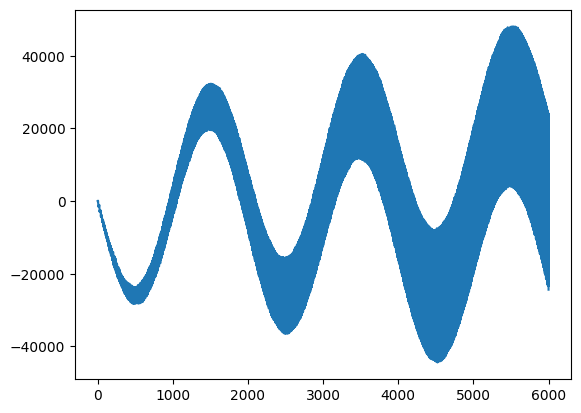

In [12]:
plt.plot(tractions[:, 21])

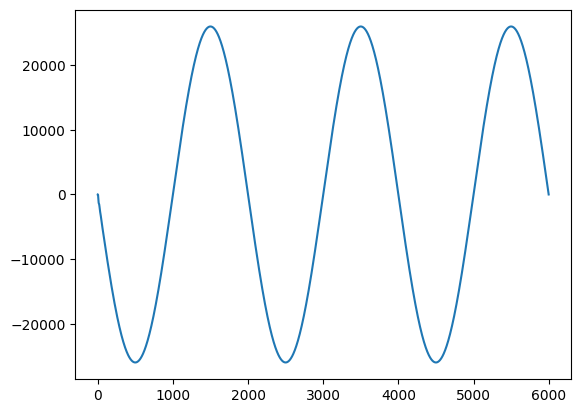

In [19]:
plt.plot(tractions2[:, 21])

In [13]:
tractions[500:1500, 21].max()

np.float64(49950.817643537834)

In [14]:
tractions[2500:3500, 21].max()

np.float64(49950.817643537805)

In [1]:
import numpy as np

In [2]:
arr_test = np.array([1, 2, 3])

In [12]:
np.concatenate(np.dstack((arr_test, arr_test, arr_test, arr_test))[0])

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])